In [68]:
import sys

sys.path.append("../")

In [69]:
import pandas as pd
import numpy as np
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from stats_arb.tests import adf_test, kpss_test, cal_half_life, pp_test
from datetime import datetime, timedelta
from ta.volatility import BollingerBands

import matplotlib.pyplot as plt


In [70]:
import requests
import json
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt


def to_dataframe(json_data):
    df = pd.DataFrame(json_data, columns=['OpenTime', 'Open', 'High', 'Low', 'Close', 'Volume', 'CloseTime', 'BaseAssetVolume', 'NbTrades', 'TakerBuyVol', 'TakerBuyBaseAssetVol', 'Ignore'])
    df.drop(columns=['CloseTime', 'BaseAssetVolume', 'NbTrades', 'TakerBuyVol', 'TakerBuyBaseAssetVol', 'Ignore'], inplace=True)
    df['OpenTime'] = pd.to_datetime(df['OpenTime'], unit='ms')
    df.set_index(keys=['OpenTime'], inplace=True)

    df[['Open', 'High', 'Low', 'Close', 'Volume']] = df[['Open', 'High', 'Low', 'Close', 'Volume']].astype('float32')

    return df


def get_klines(base_url, symbol, interval='1m'):
    end_time = int(datetime.utcnow().timestamp() * 1000)
    url = f"{base_url}/klines?symbol={symbol}&limit=1000&interval={interval}&endTime={end_time}"

    headers = {
        'Content-Type': 'application/json'
    }

    response = requests.request("GET", url, headers=headers)

    df = to_dataframe(response.json())
    return df


def get_futures_data(symbol, interval='1m'):
    # 
    return get_klines('https://fapi.binance.com/fapi/v1', symbol, interval=interval)



def get_coinm_data(symbol, interval='1m'):
    # 
    return get_klines('https://dapi.binance.com/dapi/v1', symbol, interval=interval)


def get_spot_data(symbol, interval='1m'):
    return get_klines('https://api.binance.com/api/v3', symbol, interval=interval)


In [82]:
# symbols = pd.read_csv(f'{DATA_PATH}/../symbols.csv')['symbol'].values.tolist()
symbols = ['BTC', 'ETH', 'BNB', 'XRP', 'ADA', 'SOL', 
        'LUNA', 'AVAX', 'DOT', 'DOGE', 'SHIB', 'UST', 'MATIC', 
        'ATOM', 'LTC', 'LINK', 'NEAR', 'ATOM', 'ALGO']
symbols = [f'{s}USDT' for s in symbols]

data = []

for symbol in symbols:
    df = get_futures_data(symbol=symbol, interval='5m')

    df.rename(columns={'Close': symbol}, inplace=True)
    # the data is too long, just limit to recent period
    data.append(np.log(df[symbol]))

df = pd.concat(data, axis=1)
df = df.dropna(axis=1, how='all')
# df.dropna(inplace=True, how='any')

df.head()

,BTCUSDT,ETHUSDT,BNBUSDT,XRPUSDT,ADAUSDT,SOLUSDT,LUNAUSDT,AVAXUSDT,DOTUSDT,DOGEUSDT,MATICUSDT,ATOMUSDT,LTCUSDT,LINKUSDT,NEARUSDT,ATOMUSDT,ALGOUSDT
OpenTime,,,,,,,,,,,,,,,,,
2022-04-26 10:45:00,10.605230,8.004266,5.990164,-0.385957,-0.121829,4.606569,4.566429,4.268578,2.883683,-1.829025,0.279297,3.093358,4.648325,2.587388,2.688256,3.093358,-0.339256
2022-04-26 10:50:00,10.605188,8.004002,5.990364,-0.387871,-0.122055,4.606270,4.566398,4.267317,2.884186,-1.829711,0.278843,3.092451,4.648325,2.587914,2.688051,3.092451,-0.340239
2022-04-26 10:55:00,10.605793,8.004035,5.991264,-0.387429,-0.121829,4.606270,4.564848,4.267597,2.884074,-1.830209,0.279751,3.091270,4.648230,2.588065,2.688392,3.091270,-0.339818
2022-04-26 11:00:00,10.605471,8.003587,5.989738,-0.389789,-0.123524,4.606170,4.565650,4.267457,2.883291,-1.839040,0.278843,3.089450,4.646984,2.587463,2.689343,3.089450,-0.340239
2022-04-26 11:05:00,10.603139,8.001847,5.987030,-0.394525,-0.126811,4.602767,4.562858,4.263947,2.877962,-1.846110,0.271858,3.080579,4.643140,2.581050,2.682596,3.080579,-0.346583


In [83]:
# df.tail()

In [84]:
p = 1
COINTEGRATION_CONFIDENCE_LEVEL = 90

# the 90%, 95%, and 99% confidence levels for the trace statistic and maximum 
# eigenvalue statistic are stored in the first, second, and third column of 
# cvt and cvm, respectively
confidence_level_cols = {
    90: 0,
    95: 1,
    99: 2
}
confidence_level_col = confidence_level_cols[COINTEGRATION_CONFIDENCE_LEVEL]


def test_johansen(symbol_pairs):
    df_t = df[symbol_pairs].copy()
    df_t.dropna(inplace=True)

    # The second and third parameters indicate constant term, with a lag of 1. 
    result = coint_johansen(df_t, 0, p)

    trace_crit_value = result.cvt[:, confidence_level_col]
    eigen_crit_value = result.cvm[:, confidence_level_col]
#     print("trace_crit_value",trace_crit_value)
#     print("eigen_crit_value",eigen_crit_value)
#     print("lr1",result.lr1)
#     print("lr2",result.lr2)

    # The trace statistic and maximum eigenvalue statistic are stored in lr1 and lr2;
    # see if they exceeded the confidence threshold
    if np.all(result.lr1 >= trace_crit_value) and np.all(result.lr2 >= eigen_crit_value):
        # print(f"{symbol_pairs} are cointegrated")
        # The first i.e. leftmost column of eigenvectors matrix, result.evec, contains the best weights.
        v1= result.evec[:,0:1]
        hr=v1/-v1[1] #to get the hedge ratio divide the best_eigenvector by the negative of the second component of best_eigenvector
        #the regression will be: close of symbList[1] = hr[0]*close of symbList[0] + error
        #where the beta of the regression is hr[0], also known as the hedge ratio, and
        #the error of the regression is the mean reverting residual signal that you need to predict, it is also known as the "spread"
        #the spread = close of symbList[1] - hr[0]*close of symbList[0] or alternatively (the same thing):
        #do a regression with close of symbList[0] as x and lose of symbList[1] as y, and take the residuals of the regression to be the spread.
        coint_pair = dict(hedge_ratio=v1[:, 0])
        for i, s in enumerate(symbol_pairs):
            coint_pair[f'sid_{i+1}'] = s

        cointegrating_pairs.append(coint_pair)



In [85]:

import itertools as it

nb_symbols = 3
cointegrating_pairs = []

#get symbol pairs
pairs = list(it.combinations(symbols, nb_symbols))

for pair in pairs:
    try:
        test_johansen(list(pair))
    except Exception:
        pass

coint_df = pd.DataFrame(cointegrating_pairs)
coint_df.head()

,hedge_ratio,sid_1,sid_2,sid_3
0,"[55.521733658365186, -15.35018623140896, -85.4...",BNBUSDT,DOGEUSDT,LTCUSDT
1,"[265.7971624648741, 0.28371526838591277, -247....",ADAUSDT,SOLUSDT,DOTUSDT
2,"[205.87594908101556, -7.099903136868308, -168....",ADAUSDT,SOLUSDT,LINKUSDT
3,"[266.2580142717018, -249.66014182707434, -0.32...",ADAUSDT,DOTUSDT,DOGEUSDT
4,"[268.65710558432863, -242.0275498898755, -7.95...",ADAUSDT,DOTUSDT,LINKUSDT


In [86]:
coint_df.to_csv('coint_df.csv')


In [87]:
def calculate_spread(df, selected_row, hedge_ratio):
    spread = None
    for i in range(nb_symbols):
        if spread is None:
            spread = df[coint_df[f'sid_{i + 1}'].iloc[selected_row]] * hedge_ratio[i]
        else:
            spread += df[coint_df[f'sid_{i + 1}'].iloc[selected_row]] * hedge_ratio[i]
    
    spread.dropna(inplace=True)
    return spread


critical_val = 0.005

def find_stationary_portfolio():
    data = []
    for i, _ in coint_df.iterrows():
        hedge_ratio = coint_df.iloc[i]['hedge_ratio']
        _df = df.copy()
        spread = calculate_spread(_df, i, hedge_ratio)
            
        half_life = cal_half_life(spread)
        pairs_name = coint_df[[col for col in coint_df.columns if col != 'hedge_ratio']].iloc[i].values
        # print(i, pairs_name, 'is stationary with half life', half_life)
        # print(' ')
        data.append({
            'i': i,
            'pairs': pairs_name,
            'half_life': half_life
        })
    
    return pd.DataFrame(data)


stationary_df = find_stationary_portfolio()
if len(stationary_df) > 0:
    stationary_df.sort_values(by=['half_life'], inplace=True)

In [88]:
stationary_df

,i,pairs,half_life
0,0,"[BNBUSDT, DOGEUSDT, LTCUSDT]",57.985629
5,5,"[ADAUSDT, DOGEUSDT, ALGOUSDT]",203.961970
2,2,"[ADAUSDT, SOLUSDT, LINKUSDT]",3507.581716
1,1,"[ADAUSDT, SOLUSDT, DOTUSDT]",4618.479293
3,3,"[ADAUSDT, DOTUSDT, DOGEUSDT]",4674.880951
4,4,"[ADAUSDT, DOTUSDT, LINKUSDT]",4693.569006


In [89]:
selected_row = stationary_df[stationary_df['i'] == 0]['i'].iloc[-1]
print(selected_row)
hedge_ratio = coint_df.iloc[selected_row]['hedge_ratio']
spread = calculate_spread(df, selected_row, hedge_ratio)
# spread = spread.iloc[-500:]

0


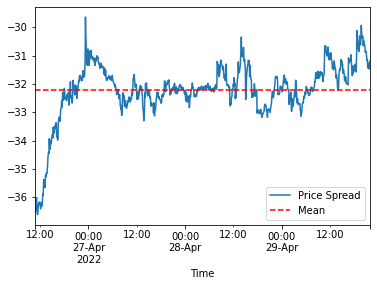

In [90]:
spread.plot() # Plot the spread
plt.axhline(spread.mean(), color='red', linestyle='--') # Add the mean
plt.xlabel('Time')
plt.legend(['Price Spread', 'Mean'])

In [91]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

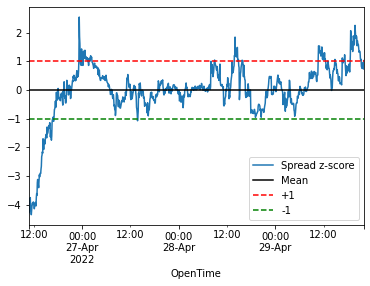

In [92]:
zscore(spread).plot()
plt.axhline(zscore(spread).mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Spread z-score', 'Mean', '+1', '-1'])